In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

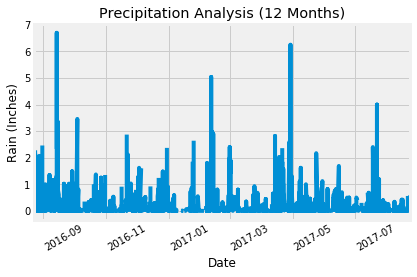

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12mo = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_pre = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(data_pre, columns=['date', 'precipitation'])
precip['date'] = pd.to_datetime(precip['date'], format='%Y-%m-%d')
precip.set_index('date')

# Sort the dataframe by date
precip = precip.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip.plot('date', 'precipitation', legend=False)
plt.title('Precipitation Analysis (12 Months)')
plt.xlabel('Date')
plt.ylabel('Rain (Inches)')
plt.xticks(ha='left')
plt.savefig('Images/Precipitation.png')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip.describe().round(3)

,precipitation
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


In [12]:
# Design a query to show how many stations are available in this dataset?
total_sta = session.query(func.count(Station.station)).first()
total_sta

(9)

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activ_sta = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activ_sta = pd.DataFrame(activ_sta, columns=['Station', 'Count'])
activ_sta

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_obs = activ_sta['Station'][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == most_obs).all()

[(54.0, 71.66378066378067, 85.0)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tot_obs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_obs).all()
tot_hist = pd.DataFrame(tot_obs)
tot_hist.head()

,station,tobs
0,USC00519281,70.0
1,USC00519281,62.0
2,USC00519281,74.0
3,USC00519281,75.0
4,USC00519281,74.0


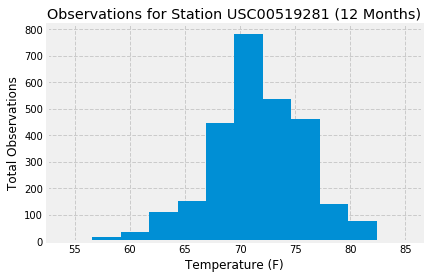

In [16]:
tot_hist.plot.hist(by='Station', bins=12, figsize=(6,4), legend=False)
plt.grid()
plt.title('Observations for Station ' + most_obs + ' (12 Months)')
plt.xlabel('Temperature (F)')
plt.ylabel('Total Observations')
plt.grid(linestyle='dashed')
plt.savefig('Images/StationTemps.png')
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vac_temp = calc_temps('2017-01-10', '2017-01-24')
vac_temp

[(62.0, 70.79347826086956, 81.0)]

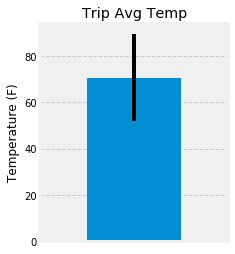

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacation = pd.DataFrame(vac_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = vacation['Avg Temp']
min_max = vacation.iloc[0]['Max Temp'] - vacation.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max, figsize=(3,4))
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.xticks([])
plt.grid(linestyle='dashed')
plt.savefig('Images/VacationTemps.png')
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
match_date = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude,
                           Station.longitude, Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2017-01-10')\
.filter(Measurement.date <= '2017-01-24')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())
rainfall = pd.DataFrame(match_date, columns=['Precipitation', 'Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
rainfall

,Precipitation,Station,Name,Latitude,Longitude,Elevation
0,3.58,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.29,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.28,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.23,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,0.20,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,0.02,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
